In [1]:
import numpy as np
import sys
sys.path.append("../..")
from libs.speech_vgg import speechVGG
from keras.models import Model
from libs.data_generator import log_standardize, pad_spec
import soundfile as sf
from scipy.signal import stft
from glob import glob
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
np.random.seed(0)

Using TensorFlow backend.


In [2]:
cd ../..

/home/beckmann/SpeechVGG


### Defining the functions we will need

In [3]:
def audio_to_input(audio_file, audio_len=None):
    audio = sf.read(audio_file)
    audio = audio[0]
    if audio_len and len(audio) > audio_len:
        i = np.random.randint(len(audio) - audio_len + 1)
        audio = audio[i:i+audio_len]
    f, t, seg_stft = stft(audio,
                        window='hamming',
                        nperseg=256,
                        noverlap=128)
    mag_spec = np.abs(seg_stft)
    spec_tmp = np.swapaxes(mag_spec, 0, 1)
    data_tmp = spec_tmp[..., np.newaxis]
    data_tmp[:,:,0] = log_standardize(data_tmp[:,:,0])
    data_tmp= np.delete(data_tmp, (128), axis=1)
    return data_tmp

In [4]:
def clips_to_features_rand(clips, model, num_random_patches=1):
    specs = []
    for clip in clips:
        for n in range(num_random_patches):
            specs.append(audio_to_input(clip, 16200))
    #specs = np.array([pad_spec(spec) for spec in specs])
    specs = np.array([spec for spec in specs])
    feats = model.predict(specs)
    a, b, c, d = np.shape(feats)
    feats_small = np.zeros((len(clips), b, c, d))
    for i in range(0, len(feats), num_random_patches):
        feat_tmp = np.mean(feats[i:i+num_random_patches], axis=0)
        feats_small[int(i/num_random_patches), ...] = feat_tmp
    return feats_small.reshape(len(clips), -1)

In [5]:
def remove_short_clips(clips, length=16200):
    good_idxs = []
    for i, clip in enumerate(clips):
        audio = sf.read(clip)
        audio = audio[0]
        if len(audio)>=length:
            good_idxs.append(i)
    clips=np.array(noise_clips)[good_idxs]
    return clips

### Load model and build extractor
Let's now load ur model and build an extractor that computes the output of the last pooling block as our features.

In [6]:
# load model
model = speechVGG(
            include_top=False,
            input_shape=(128, 128, 1),
            classes=3000, # not important
            pooling=None,
            weights='/home/beckmann/speechVGG_models/460hours_3000words_weights.19-0.28.h5',
            transfer_learning=False
        )

In [7]:
# feature extractor
sVGG_extractor = Model(inputs=model.input,
                       outputs=model.get_layer('block5_pool').output)

### Load data
Now we load the data and remove short clips of less than a second. All short clips are noise clips and this will make them to distinguishable to our model that pads clips that are shorter than a second.

In [8]:
music_clips  = glob('/home/beckmann/musan/music/*/*.wav')
noise_clips  = glob('/home/beckmann/musan/noise/*/*.wav')
speech_clips = glob('/home/beckmann/musan/speech/*/*.wav')

In [9]:
noise_clips = remove_short_clips(noise_clips)

### Extract features
Now we extract representations of each audio clip from our data. We randomly select three one second long patches in each clip and average the output of the feature extractor. 

In [10]:
# extracting features
features_music  = clips_to_features_rand(music_clips, sVGG_extractor, 3)
features_speech = clips_to_features_rand(speech_clips, sVGG_extractor, 3)
features_noise  = clips_to_features_rand(noise_clips, sVGG_extractor, 3)

In [11]:
# concatenate features and build corresponding label list.
features = np.concatenate((features_speech, features_music, features_noise))
labels = np.concatenate((np.zeros(len(features_speech)), np.ones(len(features_music)), 2*np.ones(len(features_noise))))                                                                                   

### TSNE – Data visualization
Now we can visualize our obtained features reducing them to two dimensions with TSNE.

In [12]:
# tsne
tsne = TSNE(n_components=2).fit_transform(features)

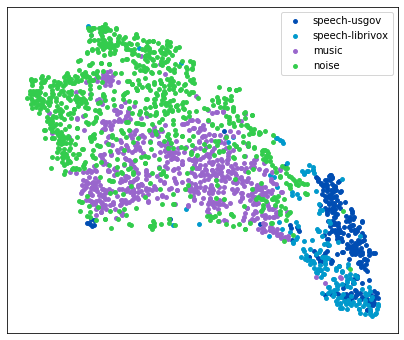

In [13]:
# plotting
clabels = np.concatenate((np.zeros(253), np.ones(len(features_speech)-253), 2*np.ones(len(features_music)), 3*np.ones(len(features_noise))))                                                                                   
plt.scatter(tsne[clabels==0,0], tsne[clabels==0,1], label='speech-usgov', color=[0,0.3,0.7,1], s=15)
plt.scatter(tsne[clabels==1,0], tsne[clabels==1,1], label='speech-librivox', color=[0,0.6,0.8,1], s=15)
plt.scatter(tsne[clabels==2,0], tsne[clabels==2,1], label='music', color=[0.6,0.4,0.8,1], s=15)
plt.scatter(tsne[clabels==3,0], tsne[clabels==3,1], label='noise', color=[0.2,0.8,0.3,1], s=15)
plt.legend()

plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)
plt.tick_params(
    axis='y',
    which='both',
    left=False,
    right=False,
    labelleft=False)
fig = plt.gcf()
fig.set_size_inches(7, 6)
plt.savefig('/home/beckmann/scatter.pdf')

### Classification
Finally we can use the features to classify into speech, music and noise using a logistic regression.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=2)
logreg = LogisticRegression(max_iter=10000, penalty='l2', C=10)
logreg.fit(X_train, y_train)
y_test_predict = logreg.predict(X_test)
accuracy_score(y_test, y_test_predict)

0.8984771573604061